In [1]:
import numpy as np
import json
from pprint import pprint

from collections import defaultdict
import operator

import matplotlib.pyplot as plt; plt.rcdefaults()


import seaborn as sns

import sys
sys.path.append('/projects2/refer360test/src')
import os
from tqdm import tqdm
from utils import rad2degree
from panoramic_camera import PanoramicCamera as camera


In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vcirik/bin/anaconda2/envs/refer360sim/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed tw

In [2]:
def calculateDistance(gt_lat,gt_lng,pr_lat,pr_lng):
  return ((gt_lat - pr_lat)**2 + (gt_lng  - pr_lng)**2)**0.5

In [3]:
def showActionInstance(instance):
  cat2loc = {'restaurant': 'indoor',
             'shop': 'indoor',
             'expo_showroom': 'indoor',
             'living_room': 'indoor',
             'bedroom': 'indoor',
             'street': 'outdoor',
             'plaza_courtyard': 'outdoor',
             }
  prefix = '../../data/refer360images/'

  img_category = '_'.join(instance['imageurl'].split(
      '/')[-1].split('.')[0].split('_')[2:])
  pano_name = "_".join(instance['imageurl'].split(
      '/')[-1].split('.')[0].split('_')[:2]) + ".jpg"

  img_loc = cat2loc[img_category]
  pano_path = '{}/{}/{}'.format(
      img_loc, img_category, pano_name)
  image_path = os.path.join(prefix,pano_path)
  
  center = instance['action_list'].split('_')[-1].split('|')[-1].split(',')

  center_lat, center_lng = float(center[0]), float(center[1])

  gt_lng, gt_lat = instance['gt_longitude'],instance['gt_latitude']
  pred_lng, pred_lat = instance['pred_longitude'],instance['pred_latitude']
  
  center_latitude, center_longitude  = rad2degree(center_lat, center_lng)
  gt_latitude, gt_longitude  = rad2degree(gt_lat, gt_lng, adjust = True)
  pred_latitude, pred_longitude = rad2degree(pred_lat, pred_lng, adjust = True)


  cam = camera(output_image_shape=(400,400))  
  cam.load_img(image_path)
  cam.look(center_latitude, center_longitude)

  gt_coors = cam.get_image_coordinate_for(gt_latitude,gt_longitude)
  pred_coors = cam.get_image_coordinate_for(pred_latitude,pred_longitude)

  fov = cam.get_image()
  size = 5
  fov[gt_coors[0]-size:gt_coors[0]+size,gt_coors[1]-size:gt_coors[1]+size,0] = 255.
  fov[gt_coors[0]-size:gt_coors[0]+size,gt_coors[1]-size:gt_coors[1]+size,1:] = 0

  fov[pred_coors[0]-size:pred_coors[0]+size,pred_coors[1]-size:pred_coors[1]+size,-1] = 255.
  fov[pred_coors[0]-size:pred_coors[0]+size,pred_coors[1]-size:pred_coors[1]+size,:-1] = 0

  plt.imshow(fov)

  degree_dist = calculateDistance(gt_latitude, gt_longitude, pred_latitude, pred_longitude)
  pixel_distance = calculateDistance(gt_coors[1], gt_coors[0], pred_coors[1], pred_coors[0])

  print('ground truth coordinates [y,x](RED):',gt_coors)
  print('predicted coordinates [y,x](BLUE):',pred_coors)

  print('Degrees {} Pixels {}'.format(degree_dist,pixel_distance))  

In [4]:
data = json.load(open('../../data/train.json'))

In [5]:
print(data[0])

{'date': '2019-10-01T17:59:29.542016Z', 'refexp': "|||turn until you're facing the counter that has the word daygum on it's display.|||behind the display, on the wall, you'll see a painted sun.|||waldo is on the left side of the sun's circle.", 'turkerid': 'A1QA5EWFMNKGTA', 'imageurl': 'https://s3.amazonaws.com/refer360/sun360images_4552x2276/pano_apqqbmmivfquan_restaurant.jpg', 'follow_count': 1, 'annotationid': 4395, 'longitude': 0.1661545689364925, 'feedback_text': 'kwyPXEEwJQqwtbGyTkxprewRlMgboFBsYUasIaYFGBNXJtRERT', 'session': 's03', 'actions': [{'pred_longitude': 0.1723856568506029, 'pred_latitude': 4.173017418895537, 'turkerid': 'A1F1BIPJR11LSR', 'annotationid': 4395, 'action_list': '|5.347537267283694,-0.6130369722905904|2.8235364129235627,1.0621791033255708|3.271213366060109,0.6066481685550511|4.0448305570065965,0.02152653682395167|5.183657893932898,-0.28477874690105454|0.2906273359667929,-0.44185837958054597|1.511921480049825,-0.34761059997285404|2.5211581200155457,-0.1473340

In [6]:
act_instances = {}
for instance in data:
  for action in instance['actions']:
    action['gt_latitude'] = instance['latitude']
    action['gt_longitude'] = instance['longitude']
    action['imageurl'] = instance['imageurl']
    
    act_instances[action['actionid']] = action
      

In [7]:
print(act_instances[2574])

{'pred_longitude': -0.712832463605673, 'pred_latitude': 0.7948473362606994, 'turkerid': 'A1VW8Y7XCV3DRW', 'annotationid': 2178, 'action_list': '|4.481753406561634,1.24247421970359|4.38750562695394,0.40995216650229427|4.395359608587915,-0.0848486764380989|4.945138322966129,-0.08877566725508634|4.960846286234078,-0.07699469480412446|4.960846286234078,-0.07699469480412446_|5.467428101625436,-0.4618397948688746|6.076111678258464,-0.39508095098009033|0.7039882406199168,-0.47362076731983604|1.5875611744420448,-0.49718271222175936|2.4829150807151357,-0.6149924367313773|3.5981804727395157,-0.2929791897384231|4.281476874895298,-0.5089636846727212|4.968700267868072,-0.36759201526118|5.8247842659712905,-0.37544599689515357|0.3269971221891516,-0.5168176663066939|0.3269971221891516,-0.5168176663066939|5.750171440448531,-0.36759201526117913|5.573456853684105,-0.3204681254573316|5.573456853684105,-0.3204681254573316|5.573456853684105,-0.3204681254573316|5.573456853684105,-0.3204681254573316|5.5734568

ground truth coordinates [y,x](RED): (180, 197)
predicted coordinates [y,x](BLUE): (284, 243)
Degrees 31.234790086957066 Pixels 113.718951806636


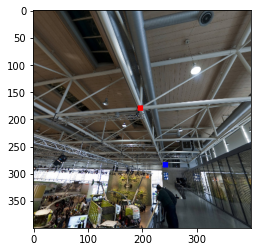

In [8]:
showActionInstance(act_instances[2972])